In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip /content/gdrive/MyDrive/Video_training/takehome.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/Malignant/1530.jpg  
  inflating: train/Malignant/1531.jpg  
  inflating: train/Malignant/1532.jpg  
  inflating: train/Malignant/1533.jpg  
  inflating: train/Malignant/1534.jpg  
  inflating: train/Malignant/1535.jpg  
  inflating: train/Malignant/1536.jpg  
  inflating: train/Malignant/1537.jpg  
  inflating: train/Malignant/1538.jpg  
  inflating: train/Malignant/1539.jpg  
  inflating: train/Malignant/154.jpg  
  inflating: train/Malignant/1540.jpg  
  inflating: train/Malignant/1541.jpg  
  inflating: train/Malignant/1542.jpg  
  inflating: train/Malignant/1543.jpg  
  inflating: train/Malignant/1544.jpg  
  inflating: train/Malignant/1545.jpg  
  inflating: train/Malignant/1546.jpg  
  inflating: train/Malignant/1547.jpg  
  inflating: train/Malignant/1548.jpg  
  inflating: train/Malignant/1549.jpg  
  inflating: train/Malignant/155.jpg  
  inflating: train/Malignant/1550.jpg  
  inflating: train/Malignant/15

In [3]:
# Install Torch if needed
# !pip install torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image


In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Set batch size and image dimensions
batch_size = 128
img_height = 256
img_width = 256

# Augmentation for training data
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(p=0.5),           # Flip 50% of images
    transforms.RandomRotation(degrees=20),             # Randomly rotate +/- 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jitter
    transforms.RandomResizedCrop((img_height, img_width), scale=(0.8, 1.0)), # Random crop zoom
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet means & std
                         std=[0.229, 0.224, 0.225])
])

# Simple transform for validation & test (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Paths to dataset
train_dir = "/content/train"
test_dir = "/content/test"

# Load datasets
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)  # Augment train
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)          # Plain test

# Split training data into train & validation sets (80-20 split)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Apply train transform to training split, test transform to validation split
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Override validation dataset's transform (no augmentation for val)
val_dataset.dataset.transform = test_transform

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print class names
class_names = full_train_dataset.classes
print("Class Names:", class_names)



Class Names: ['Benign', 'Malignant']


In [5]:
import torch.nn as nn
import math

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        # SE
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_down = nn.Conv2d(
            planes * 4, planes // 4, kernel_size=1, bias=False)
        self.conv_up = nn.Conv2d(
            planes // 4, planes * 4, kernel_size=1, bias=False)
        self.sig = nn.Sigmoid()
        # Downsample
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out1 = self.global_pool(out)
        out1 = self.conv_down(out1)
        out1 = self.relu(out1)
        out1 = self.conv_up(out1)
        out1 = self.sig(out1)

        if self.downsample is not None:
            residual = self.downsample(x)

        res = out1 * out + residual
        res = self.relu(res)

        return res

class SEResNet(nn.Module):

    def __init__(self, block, layers, num_classes=2):
        self.inplanes = 64
        super(SEResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 128, layers[0])
        self.layer2 = self._make_layer(block, 192, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(14)
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Examples of Se-Resnet
# Use _make_layer to make a block
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SEResNet(Bottleneck, [3, 4, 6, 3], num_classes=2).to(device)    # se_resnet50
print(model)

SEResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (global_pool): AdaptiveAvgPool2d(output_size=1)
      (conv_down): Conv2d(512,

In [6]:
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
epochs = 100
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, factor=0.5,mode = 'max',verbose=True)
#

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100 * correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= total
        val_acc = 100 * correct / total
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # Step the scheduler
        scheduler.step(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model
epochs = 100
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs
)


Epoch [1/100] - Train Loss: 0.5626, Train Acc: 76.98% - Val Loss: 0.5346, Val Acc: 80.60%
Epoch [2/100] - Train Loss: 0.5149, Train Acc: 82.29% - Val Loss: 0.5154, Val Acc: 82.79%
Epoch [3/100] - Train Loss: 0.5019, Train Acc: 83.92% - Val Loss: 0.5344, Val Acc: 81.36%
Epoch [4/100] - Train Loss: 0.4918, Train Acc: 85.13% - Val Loss: 0.4993, Val Acc: 83.96%
Epoch [5/100] - Train Loss: 0.4860, Train Acc: 85.79% - Val Loss: 0.4898, Val Acc: 85.35%
Epoch [6/100] - Train Loss: 0.4809, Train Acc: 86.13% - Val Loss: 0.5143, Val Acc: 84.34%
Epoch [7/100] - Train Loss: 0.4755, Train Acc: 86.69% - Val Loss: 0.4903, Val Acc: 84.81%
Epoch [8/100] - Train Loss: 0.4758, Train Acc: 86.90% - Val Loss: 0.4935, Val Acc: 85.69%
Epoch [9/100] - Train Loss: 0.4714, Train Acc: 87.40% - Val Loss: 0.4865, Val Acc: 85.40%
Epoch [10/100] - Train Loss: 0.4644, Train Acc: 87.72% - Val Loss: 0.4853, Val Acc: 85.90%
Epoch [11/100] - Train Loss: 0.4626, Train Acc: 88.12% - Val Loss: 0.4783, Val Acc: 87.08%
Epoch [1

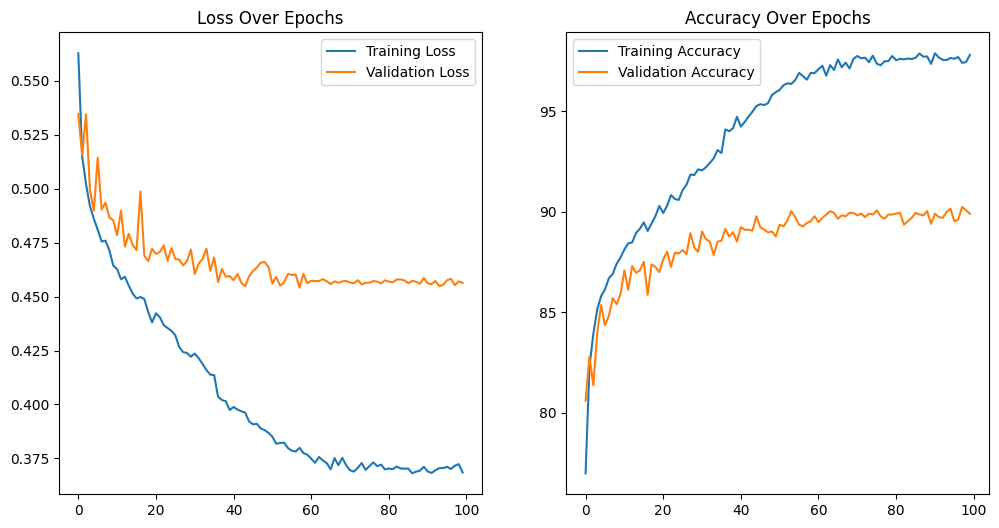

In [8]:
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss_history, label='Training Loss')
plt.plot(range(epochs), val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_acc_history, label='Training Accuracy')
plt.plot(range(epochs), val_acc_history, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()


In [9]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")

# Evaluate
evaluate_model(model, test_loader)


Test Accuracy: 93.55%


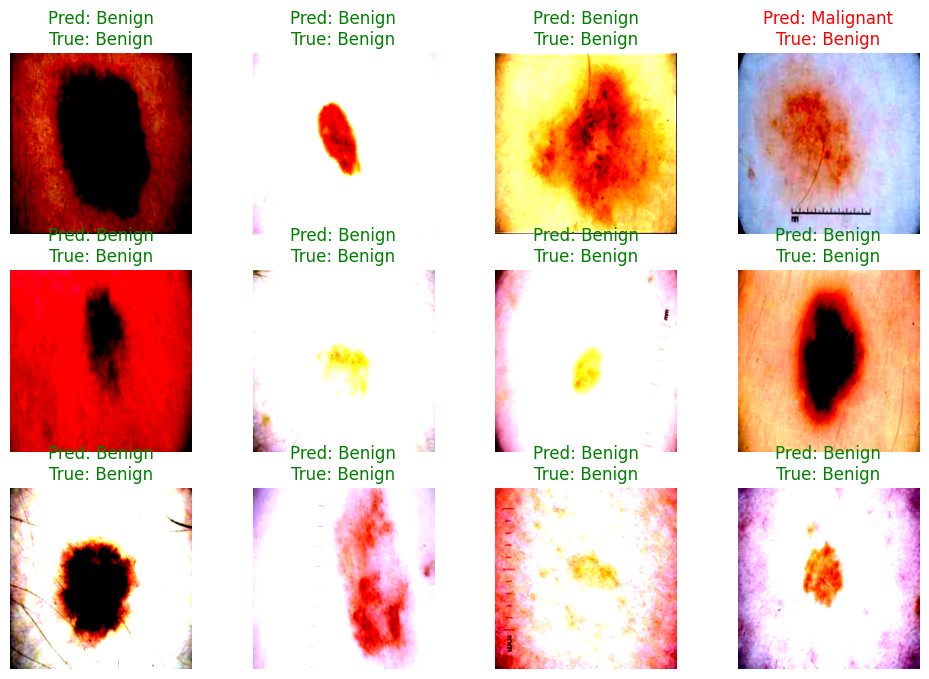

In [10]:
def predict_and_plot(model, test_loader, class_names):
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

    plt.figure(figsize=(12, 8))
    for i in range(min(12, len(images))):
        plt.subplot(3, 4, i+1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        color = "green" if predictions[i] == labels[i] else "red"
        plt.title(f"Pred: {class_names[predictions[i]]}\nTrue: {class_names[labels[i]]}", color=color)
        plt.axis("off")

    plt.show()

# Run visualization
predict_and_plot(model, test_loader, class_names)
